In [5]:
%pip install textblob
%pip install spacy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.


In [8]:
import pandas as pd
from textblob import TextBlob
import spacy
import re

In [14]:
# ================================================================
# LOAD THE DATA
# ================================================================

# Specify the file path
gptrc_file = 'GPTRC_GPT_Responses_Corpus.xlsx'

# Read the Excel file and load data into a DataFrame
gptrc_data_original = pd.read_excel(gptrc_file)

In [18]:
# Make a copy of original data
gptrc_data = gptrc_data_original
gptrc_data.head()

,question_no,question,keywords,unfiltered_answer,unfiltered_answer_length,thinking_time,response_completion_time
0,1,"Can you tell me about Mr. Narendra Modi, the c...","Mr. Narendra Modi, Prime Minister, India",Sure! Mr. Narendra Modi is the current Prime M...,84,265.0,1.2
1,2,Can you tell me about Mr. Abraham Lincoln?,Mr. Abraham Lincoln,Certainly! Mr. Abraham Lincoln was the 16th Pr...,91,350.0,1.4
2,3,"If I spend 10 hours a day sleeping, 2 eating a...","10 hours, sleeping, 2 hours, eating, 5 hours, ...","If you spend 10 hours sleeping, 2 hours eating...",27,145.0,1.1
3,4,Two birds sit before a bird and two birds sit ...,"Two birds, sit before, bird, two birds, sit af...",If we assume that there is only one bird sitti...,109,458.0,1.2
4,5,There’s a one-story house in which everything ...,"one-story house, yellow, walls, yellow, doors,...",If the house is one-story and everything insid...,34,231.0,1.1


In [19]:
gptrc_data.shape

(50134, 7)

In [21]:
# 1.Remove unnecessary columns
gptrc_data = gptrc_data.drop(columns=['question_no', 'thinking_time', 'response_completion_time'])
gptrc_data.head()

,question,keywords,unfiltered_answer,unfiltered_answer_length
0,"Can you tell me about Mr. Narendra Modi, the c...","Mr. Narendra Modi, Prime Minister, India",Sure! Mr. Narendra Modi is the current Prime M...,84
1,Can you tell me about Mr. Abraham Lincoln?,Mr. Abraham Lincoln,Certainly! Mr. Abraham Lincoln was the 16th Pr...,91
2,"If I spend 10 hours a day sleeping, 2 eating a...","10 hours, sleeping, 2 hours, eating, 5 hours, ...","If you spend 10 hours sleeping, 2 hours eating...",27
3,Two birds sit before a bird and two birds sit ...,"Two birds, sit before, bird, two birds, sit af...",If we assume that there is only one bird sitti...,109
4,There’s a one-story house in which everything ...,"one-story house, yellow, walls, yellow, doors,...",If the house is one-story and everything insid...,34


In [51]:
# 2.Remove questions based on length -> (play from 50 to 100 word count
gptrc_data = gptrc_data[gptrc_data['unfiltered_answer_length'] >= 100]
len(gptrc_data)

24710

In [52]:
def write_questions_to_file(questions, output_file):
    with open(output_file, 'w') as file:
        for question in questions:
            file.write(question + '\n')

    print(f"{len(questions)} questions have been stored in '{output_file}'")

In [54]:
column_name = 'question'
gpt_questions_column = gptrc_data[column_name]
questions = gpt_questions_column.tolist()

numbered_questions = []
non_numbered_questions = []

# Loop through each question and classify it based on whether it contains numbers
for question in questions:
    if bool(re.search(r'\d', question)):
        numbered_questions.append(question)
    else:
        non_numbered_questions.append(question)

number_based_questions_output_file = "filtered-questions/numbered_questions.txt"
non_number_based_questions_output_file = "filtered-questions/non_numbered_questions.txt"

write_questions_to_file(numbered_questions, number_based_questions_output_file)
write_questions_to_file(non_numbered_questions, non_number_based_questions_output_file)

2859 questions have been stored in 'filtered-questions/numbered_questions.txt'
21851 questions have been stored in 'filtered-questions/non_numbered_questions.txt'


In [56]:
math_keywords = ['calculate', 'solve', 'equation', 'plus', 'minus', 'minimum', 'maximum', 'multiply', 'sum', 'product', 'integral', 'derivative', 'geometry', 'algebra', 'trigonometry', 'spend', 'addition', 'subtraction', 'add', 'subtract']
math_symbols = ['+', '=', '*', '/', '^', '√', 'π', '%']

# Load the English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load("en_core_web_sm")

def is_math_question(question):
    doc = nlp(question)
    # Check for mathematical symbols directly
    if any(symbol in question for symbol in math_symbols):
        return True
    # Check for mathematical keywords
    for token in doc:
        if token.lemma_.lower() in math_keywords:
            return True
    return False

mathematical_questions = [q for q in non_numbered_questions if is_math_question(q)]
non_mathematical_questions = [q for q in non_numbered_questions if not is_math_question(q)]

# Define the file paths where you want to store the questions
mathematical_questions_based_output_file = "filtered-questions/mathematical_questions.txt"
non_mathematical_questions_based_output_file = "filtered-questions/non_mathematical_questions.txt"

write_questions_to_file(mathematical_questions, mathematical_questions_based_output_file)
write_questions_to_file(non_mathematical_questions, non_mathematical_questions_based_output_file)

941 questions have been stored in 'filtered-questions/mathematical_questions.txt'
20910 questions have been stored in 'filtered-questions/non_mathematical_questions.txt'


In [57]:
def is_logical_or_reasoning_question(question):
    logical_keywords = [
        'break', 'without touching', 'sequence', 'next', 'follows', 'imagine', 'probability', 'chance', 'suppose',
        'mother', 'son', 'daughter', 'brother', 'family', 'drawn randomly', 'selected'
    ]
    pattern = re.compile('|'.join(logical_keywords), re.IGNORECASE)
    if pattern.search(question):
        return True
    return False

logical_questions = [q for q in non_mathematical_questions if is_logical_or_reasoning_question(q)]
non_logical_questions = [q for q in non_mathematical_questions if not is_logical_or_reasoning_question(q)]

# Define the file paths where you want to store the questions
logical_questions_based_output_file = "filtered-questions/logical_questions.txt"
non_logical_questions_based_output_file = "filtered-questions/non_logical_questions.txt"

write_questions_to_file(logical_questions, logical_questions_based_output_file)
write_questions_to_file(non_logical_questions, non_logical_questions_based_output_file)

799 questions have been stored in 'filtered-questions/logical_questions.txt'
20111 questions have been stored in 'filtered-questions/non_logical_questions.txt'


In [58]:
opinion_based_questions = []
non_opinion_based_questions = []

for question in non_logical_questions:
    blob = TextBlob(question)
    subjectivity = blob.sentiment.subjectivity
    if subjectivity > 0.5:
        # If the question is opinion-based, append it to the list
        opinion_based_questions.append(question)
    else:
        # If the question is not opinion-based, append it to the list
        non_opinion_based_questions.append(question)

# Define the file paths where you want to store the questions
opinion_questions_based_output_file = "filtered-questions/opinion_based_questions.txt"
non_opinion_questions_based_output_file = "filtered-questions/non_opinion_based_questions.txt"

write_questions_to_file(opinion_based_questions, opinion_questions_based_output_file)
write_questions_to_file(non_opinion_based_questions, non_opinion_questions_based_output_file)

3750 questions have been stored in 'filtered-questions/opinion_based_questions.txt'
16361 questions have been stored in 'filtered-questions/non_opinion_based_questions.txt'


In [59]:
def is_subjective_question(question):
    subjective_patterns = [
        r'\b(your)\b', r'\b(recommend)\b', r'\b(enjoy(ed)?)\b', r'\b(feel(ing)?)\b', r'\b(can I)\b',
        r'\b(strangest)\b',r'\b(played)\b',r'\b(watched)\b',r'\b(to you)\b', r'\b(do you think)\b', 
        r'\b(believe)\b', r'\b(opinion)\b', r'\b(would you)\b', r'\b(could you)\b', 
        r'\b(should)\b', r'\b(is it better to)\b',r'\b(is it wrong)\b', r'\b(is it good to)\b', 
        r'\b(how do you)\b', r'\b(predict)\b', r'\b(assume)\b', r'\b(how to|what should I do|solution to|advice)\b',
        r'\b(do you like|favorite|prefer)\b', r'\b(improve the sentence|correct|edit)\b'
    ]
    if any(re.search(pattern, question, re.IGNORECASE) for pattern in subjective_patterns):
        return True
    return False


subjective_questions = [q for q in non_opinion_based_questions if is_subjective_question(q)]
non_subjective_questions = [q for q in non_opinion_based_questions if not is_subjective_question(q)]

# Define the file paths where you want to store the questions
subjective_questions_based_output_file = "filtered-questions/subjective_questions.txt"
non_subjective_questions_based_output_file = "filtered-questions/non_subjective_questions.txt"

write_questions_to_file(subjective_questions, subjective_questions_based_output_file)
write_questions_to_file(non_subjective_questions, non_subjective_questions_based_output_file)

3901 questions have been stored in 'filtered-questions/subjective_questions.txt'
12460 questions have been stored in 'filtered-questions/non_subjective_questions.txt'


In [60]:
def is_sequence_question(question):
    # This regular expression looks for patterns like "A, B, C, D" or "1, 2, 3, 4"
    # Adjust the regular expression to match the types of sequences you expect
    sequence_pattern = re.compile(r'\b(?:[A-Za-z],\s?)+[A-Za-z]?\b|\b(?:\d,\s?)+\d?\b')
    return bool(sequence_pattern.search(question))

sequence_questions = [q for q in non_subjective_questions if is_sequence_question(q)]
non_sequence_questions = [q for q in non_subjective_questions if not is_sequence_question(q)]

# Define the file paths where you want to store the questions
sequence_questions_based_output_file = "filtered-questions/sequence_questions.txt"
non_sequence_questions_based_output_file = "filtered-questions/non_sequence_questions.txt"

write_questions_to_file(sequence_questions, sequence_questions_based_output_file)
write_questions_to_file(non_sequence_questions, non_sequence_questions_based_output_file)

9 questions have been stored in 'filtered-questions/sequence_questions.txt'
12451 questions have been stored in 'filtered-questions/non_sequence_questions.txt'


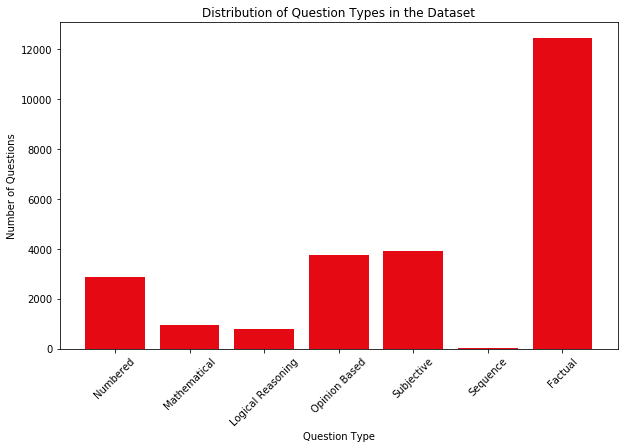

In [74]:
import matplotlib.pyplot as plt

# Categories and their corresponding counts
categories = ['Numbered', 'Mathematical', 'Logical Reasoning', 'Opinion Based', 'Subjective', 'Sequence', 'Factual']
counts = [2859, 941, 799, 3750, 3901, 9, 12451]

# Create the bar chart
plt.figure(figsize=(10, 6))  # Optional: Adjust the figure size as needed
plt.bar(categories, counts, color='#E50914')  # You can change the color as you like

# Adding titles and labels
plt.title('Distribution of Question Types in the Dataset')
plt.xlabel('Question Type')
plt.ylabel('Number of Questions')

# Optional: Rotate category names for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [76]:
filtered_questions = non_sequence_questions

In [77]:
filtered_questions_set = set(filtered_questions)

# Filter the DataFrame to keep only rows with questions in the filtered questions set
filtered_gptrc_data = gptrc_data[gptrc_data['question'].isin(filtered_questions_set)]
filtered_gptrc_data

,question,keywords,unfiltered_answer,unfiltered_answer_length
14,How would I go about finding a burried treasure?,"finding, buried treasure",Finding buried treasure is often the stuff of ...,237
22,Do you consider AI a threat to human civilizat...,"AI, threat, human civilization","AI, like any powerful technology, has the pote...",182
30,Are you familiar with the concept of Yin and Y...,"concept, Yin and Yang","Yes, I am familiar with the concept of Yin and...",255
37,"What do you understand by the term, ""copyright""?",copyright,Copyright is a legal term that refers to the e...,119
40,Do ghosts exist?,"ghosts, exist",The question of whether ghosts exist is a matt...,124
...,...,...,...,...
50108,What are the differences between Brazilian jiu...,difference brazilian jiu jitsu muay thai,Brazilian Jiu Jitsu (BJJ) and Muay Thai are bo...,243
50111,What are some best examples of Presence of mind?,best example presence mind,"1. During a road accident, a person quickly pu...",198
50118,"When Japanese people comes India, how do they ...","japanese people, langugae, india",Japanese people who come to India may face lan...,114
50124,"What was the ""core schools"" initiative that Ma...","core school initiative marissa mayer, google","Unfortunately, as an AI language model, I do n...",101


In [78]:
filtered_gptrc_data.shape

(12451, 4)

In [85]:
excel_file_path = 'filtered_gptrc_data.xlsx'

# Write the DataFrame to an Excel file
filtered_gptrc_data.to_excel(excel_file_path, index=False)

print(f"Data has been stored in '{excel_file_path}'")

Data has been stored in 'filtered_gptrc_data.xlsx'
